
# **E1 - Implementación del modelo en la predicción de precios de vehículos usados**

Lo primero es descargar e importar las librerías que utilizaremos en el modelo.

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor

Llamamos el dataset que utilizaremos para nuestra estimación de precios

In [ ]:
data = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

### Verificar datos faltantes
Lo primero que haremos con la data son validaciones iniciales para identificar datos faltantes o nulos y no tener inconvenientes en el tratamiento y modelación de datos.

In [ ]:
nulos_por_columna = data.isnull().sum()

# Muestra los resultados
print(nulos_por_columna)

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64


### Verificar cuantas categorías hay por variables
Continuamos con una validación por categorías para entender el dimensionamiento del dataset y poder encontrar algúnas alternativas en el tratamiento de los datos.

In [ ]:
for column in data.columns:
    print(f"Categorías en la columna '{column}':")
    print(data[column].value_counts())
    print("\n")

Categorías en la columna 'Price':
Price
14995    2870
13995    2762
9995     2695
12995    2679
16995    2552
         ... 
26428       1
29330       1
52827       1
52531       1
63973       1
Name: count, Length: 38222, dtype: int64


Categorías en la columna 'Year':
Year
2015    89157
2014    85365
2016    69856
2017    55926
2013    40473
2012    38783
2011    29710
2010    20800
2008    16897
2007    13801
2009    13304
2006     8978
2005     6153
2004     4272
2003     2392
2002     1465
2001      940
2000      593
2018      453
1999      370
1998      195
1997      117
Name: count, dtype: int64


Categorías en la columna 'Mileage':
Mileage
10        287
5         173
15         98
12         82
11         73
         ... 
126210      1
185425      1
128350      1
138510      1
110427      1
Name: count, Length: 139548, dtype: int64


Categorías en la columna 'State':
State
 TX    57153
 CA    45643
 FL    42244
 GA    22790
 NC    22363
 IL    21058
 VA    19851
 PA    16337
 NY

# Tratamiento de los datos
Al encontrar un número importante de categorías dentro de las variables ( State,
Make, Model) se considera realizar una agrupación de categorías para facilitar el modelamiento, el costo computacional y la complejidad del modelo. De esta manera, se realiza un top de las 20 más representativas y una nueva categoría de "otros" para asignar las de menos represetación.

In [ ]:
def agrupar_top_20(df, columna):
    # Obtener las 20 categorías más representativas
    top_20 = df[columna].value_counts().nlargest(20).index

    # Reemplazar las categorías menos frecuentes con 'Otros'
    df[columna] = df[columna].apply(lambda x: x if x in top_20 else 'Otros')
    return df

In [ ]:
data = agrupar_top_20(data, "State")
data = agrupar_top_20(data, "Make")
data = agrupar_top_20(data, "Model")

para el procesamiento de variables categóricas dentro de los modelos, se convierten estas variables en variables dummy, con el fin de que se puedan procesar como false con las variables numéricas..

In [ ]:
# Convertir en variables dummy
df_dummies = pd.get_dummies(data, columns=['State'], drop_first=True)
df_dummies = pd.get_dummies(df_dummies, columns=['Make'], drop_first=True)
df_dummies = pd.get_dummies(df_dummies, columns=['Model'], drop_first=True)

## Implementación de modelos
Para la determinación del modelo que utilizaremos como predictivo de precios de autos usados, probaremos Random Forest, regresión lineal, arbol de decisión y Xgboost y K.fold de (k=10). La métrica de evaluación será MSE.

Iniciaremos con Random Forest: De acuerdo con las iteraciones, el mejor resultado obtenido fue con "n_estimators=80" para la determinación de árboles en el bosque, frente a la eficiancia computacional y "random_state=42" como fijación de la semilla. Además, "n_splits=10" para el k- fold y
"shuffle=True" para la Mezcla de los datos antes de dividirlos.

In [ ]:
X = df_dummies.drop(columns=['Price'])  # Variables predictoras
y = df_dummies['Price']  # Variable objetivo

# Creación del modelo de Random Forest
model = RandomForestRegressor(n_estimators=80, random_state=42)

# Configuración K-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Definición de la métrica a usar (en este caso, el error cuadrático medio)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# validación cruzada
cv_results = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)

# Convertir los resultados a positivos para interpretarlos como MSE
cv_results = -cv_results

# Error cuadrático medio para cada fold
for i, mse in enumerate(cv_results):
    print(f'Fold {i+1}: MSE = {mse:.4f}')

print(f'\nMean MSE: {cv_results.mean():.4f}')

Fold 1: MSE = 52659682.8830
Fold 2: MSE = 51177401.1928
Fold 3: MSE = 52448830.0753
Fold 4: MSE = 51233991.2455
Fold 5: MSE = 52188666.5164
Fold 6: MSE = 52639421.8122
Fold 7: MSE = 52865572.2337
Fold 8: MSE = 53487912.5675
Fold 9: MSE = 52092576.1371
Fold 10: MSE = 51290372.1825

Mean MSE: 52208442.6846


## Implementación modelo con Arboles de decisión

El segundo modelo implementado es el árbol de decisión, un modelo menos complejo, pero con un procesamiento más sencillo computacionalmente, en dónde los hiperparámetros se mantienen para hacer comparables los resultados del MSE.


In [ ]:
# Creación del modelo de Árbol de Decisión
model = DecisionTreeRegressor(random_state=42)

# Configuración K-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Métrica a usar (en este caso, el error cuadrático medio)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# validación cruzada
cv_results = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)

# Convertir los resultados a positivos para interpretarlos como MSE
cv_results = -cv_results

# Imprimir el error cuadrático medio para cada fold
for i, mse in enumerate(cv_results):
    print(f'Fold {i+1}: MSE = {mse:.4f}')

# Imprimir el MSE promedio
print(f'\nMean MSE: {cv_results.mean():.4f}')

Fold 1: MSE = 81980036.2912
Fold 2: MSE = 80699802.6769
Fold 3: MSE = 82717105.6874
Fold 4: MSE = 80259059.6744
Fold 5: MSE = 81250717.9815
Fold 6: MSE = 82601120.1181
Fold 7: MSE = 82914964.5714
Fold 8: MSE = 84746893.1753
Fold 9: MSE = 81347470.3319
Fold 10: MSE = 79996503.1082

Mean MSE: 81851367.3616


De acuerdo con los resultados obtenidos hasta ahora, es el random forest el que presenta el menor MSE. Se descarta la elección del árbol de decisión por el resultado.

# Implementación de regresión lineal
Se implementa un modelo más sencillo de regresión lineal para poder analizar como se comporta, por la simplicidad del modelo, no se realiza ajuste de hiperparámetros.

In [ ]:
from sklearn.linear_model import LinearRegression

# Creación del modelo de Regresión Lineal
model = LinearRegression()

# Configuración K-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Métrica a usar (en este caso, el error cuadrático medio)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Realizar la validación cruzada
cv_results = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)

# Convertir los resultados a positivos para interpretarlos como MSE
cv_results = -cv_results

# Imprimir el error cuadrático medio para cada fold
for i, mse in enumerate(cv_results):
    print(f'Fold {i+1}: MSE = {mse:.4f}')

# Imprimir el MSE promedio
print(f'\nMean MSE: {cv_results.mean():.4f}')

Fold 1: MSE = 53877348.4258
Fold 2: MSE = 52576537.9016
Fold 3: MSE = 52516240.4831
Fold 4: MSE = 51912026.7170
Fold 5: MSE = 52697376.3830
Fold 6: MSE = 53668371.4853
Fold 7: MSE = 52422932.5549
Fold 8: MSE = 53214880.6281
Fold 9: MSE = 52104798.7786
Fold 10: MSE = 52398255.6790

Mean MSE: 52738876.9036


A pesar de que el modelo de regresión lineal es mucho más sencillo que el de random forest, los resultados del MSE fueron muy similares, con  una leve mejora en random forest, pero su costo computacional y complejidad, podría pensarse en definir el modelo de regresión lineal. Sin embargo, para el objetivo de este trabajo, definiremos hasta este momento el random forest.

# Implementación XGboos
Finalmente, consideraremos el rendimiento de Xgboost, con la deficnición de los hiperparámetros objective='reg:squarederror' para la definición de la función de pérdida que se minimizará, n_estimators=50: para stablecer el número de árboles que se crearán en el modelo y evaluar la precisión, pero también el rendimiento por los tiempos de entrenamiento y
random_state=42 para la fijación de la semilla para obtener resultados reproducibles y comparables.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

X = df_dummies.drop(columns=['Price'])  # Variables predictoras
y = df_dummies['Price']  # Variable objetivo

# Creación del modelo XGBoost
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=50, random_state=42)

# Configuración K-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Definir la métrica a usar (en este caso, el error cuadrático medio)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Realizar la validación cruzada
cv_results = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)

# Convertir los resultados a positivos para interpretarlos como MSE
cv_results = -cv_results

# Imprimir el error cuadrático medio para cada fold
for i, mse in enumerate(cv_results):
    print(f'Fold {i+1}: MSE = {mse:.4f}')

# Imprimir el MSE promedio
print(f'\nMean MSE: {cv_results.mean():.4f}')

Fold 1: MSE = 45650406.3839
Fold 2: MSE = 43649634.2356
Fold 3: MSE = 44487699.9014
Fold 4: MSE = 44251935.3963
Fold 5: MSE = 44485022.5121
Fold 6: MSE = 44816735.1259
Fold 7: MSE = 44781427.5534
Fold 8: MSE = 44747051.1181
Fold 9: MSE = 44449813.3907
Fold 10: MSE = 44079947.4878

Mean MSE: 44539967.3105


De acuerdo con los resultados obtenidos en Xgboost, podemos determinar que su MSE es el menor de las opciones evaluadas, por tanto será el modelo que se implementará en la estimación de precios con un MSE de 44539967.3105.

In [ ]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Hacemos la prueba de algúnas predicciones ejecutadas por el modelo.

In [ ]:
predictions = model.predict(X)
print(predictions)


[21344.324 24661.65  21897.363 ... 45713.13  23455.773 27939.328]


In [ ]:
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
print(f'MSE: {mse}')

MSE: 44017859.17825479


In [ ]:
import joblib
joblib.dump(model, 'xgboost_model.pkl', compress=3)

['xgboost_model.pkl']

In [ ]:
loaded_model = joblib.load('xgboost_model.pkl')

## **API**

Se procede con la carga y la función que nos conectará con la URL que presentará los resultados de la predicción.

In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

# Cargar el modelo
model = joblib.load('xgboost_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Obtener los datos del cuerpo de la solicitud
        data = request.json

        # Convertir los datos a un DataFrame
        df = pd.DataFrame(data)

        # Hacer predicciones
        predictions = model.predict(df)

        # Convertir las predicciones a una lista
        predictions_list = predictions.tolist()

        # Devolver las predicciones en formato JSON
        return jsonify(predictions=predictions_list)

    except Exception as e:
        return jsonify(error=str(e)), 400

if __name__ == '__main__':
    app.run(port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [06/Sep/2024 11:59:46] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [06/Sep/2024 11:59:46] "GET /favicon.ico HTTP/1.1" 404 -


Se realiza el entrenamiento para obtener los resultados.

In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

# Cargar el modelo
model = joblib.load('xgboost_model.pkl')
@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.json
        df = pd.DataFrame(data)

        expected_columns = [
            'Year', 'Mileage', 'State_ CA', 'State_ CO', 'State_ FL',
            'State_ GA', 'State_ IL', 'State_ IN', 'State_ KY', 'State_ MA',
            'State_ MD', 'State_ MO', 'State_ NC', 'State_ NJ', 'State_ NY',
            'State_ OH', 'State_ PA', 'State_ TN', 'State_ TX', 'State_ VA',
            'State_ WA', 'State_Otros', 'Make_Buick', 'Make_Cadillac',
            'Make_Chevrolet', 'Make_Chrysler', 'Make_Dodge', 'Make_Ford',
            'Make_GMC', 'Make_Honda', 'Make_Hyundai', 'Make_Jeep', 'Make_Kia',
            'Make_Lexus', 'Make_MINI', 'Make_Mercedes-Benz', 'Make_Nissan',
            'Make_Otros', 'Make_Ram', 'Make_Subaru', 'Make_Toyota',
            'Make_Volkswagen', 'Model_Accord', 'Model_CamaroCoupe', 'Model_CamrySE',
            'Model_Civic', 'Model_CorollaLE', 'Model_EquinoxFWD', 'Model_F-1504WD',
            'Model_F-150XLT', 'Model_FusionSE', 'Model_Grand', 'Model_Jetta',
            'Model_MalibuLT', 'Model_Otros', 'Model_Ram', 'Model_Santa',
            'Model_Sierra', 'Model_Silverado', 'Model_Super', 'Model_Town',
            'Model_Wrangler'
        ]

        for col in expected_columns:
            if col not in df.columns:
                df[col] = 0

        df = df[expected_columns]

        # Hacer predicciones
        predictions = model.predict(df)
        # Convertir las predicciones a una lista
        predictions_list = predictions.tolist()
        # Devolver las predicciones en formato JSON
        return jsonify(predictions=predictions_list)

    except Exception as e:
        return jsonify(error=str(e)), 400

if __name__ == '__main__':
    app.run(port=5000)


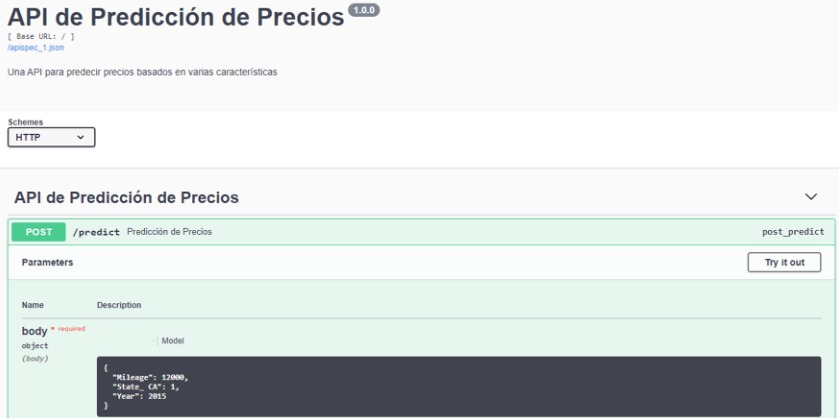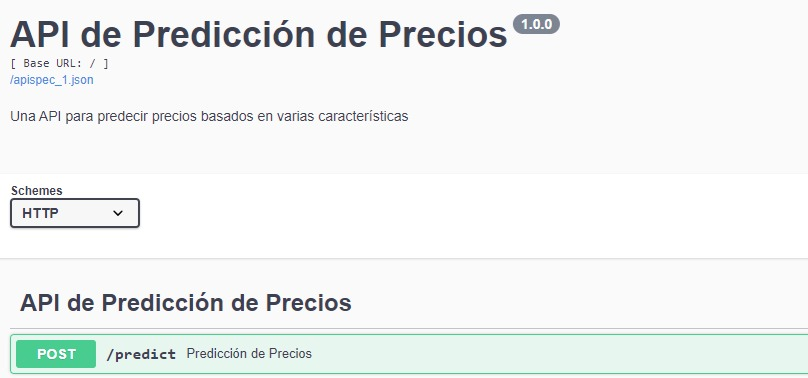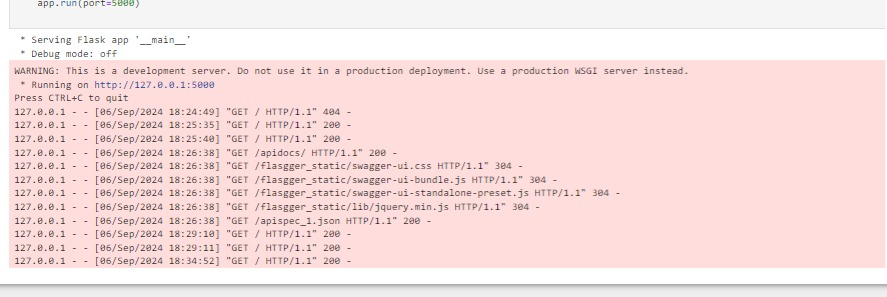